In [44]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.4f' % x) # 不使用科学计数法
pd.set_option('display.max_columns', None) # 显示所有列
pd.set_option('display.max_rows', 10) # 设定df全部显示的行数

# 一个cell做多个输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

#设置中文显示的相关参数：
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] #指定默认字体  
plt.rcParams['font.size'] = 8
#解决负号显示为方框的问题
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 6)


## 数据集导入

In [45]:
data = pd.read_csv('./data/data.csv', index_col=0, encoding='utf8')
data.head()
data.shape

# data.dtypes

,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,student_feature,repayment_capability,is_high_user,number_of_trans_from_2011,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,avg_consume_less_12_valid_month,abs,top_trans_count_last_1_month,avg_price_last_12_month,avg_price_top_last_12_valid_month,reg_preference_for_trad,trans_top_time_last_1_month,trans_top_time_last_6_month,consume_top_time_last_1_month,consume_top_time_last_6_month,cross_consume_count_last_1_month,trans_fail_top_count_enum_last_1_month,trans_fail_top_count_enum_last_6_month,trans_fail_top_count_enum_last_12_month,consume_mini_time_last_1_month,max_cumulative_consume_later_1_month,max_consume_count_later_6_month,railway_consume_count_last_12_month,pawns_auctions_trusts_consume_last_1_month,pawns_auctions_trusts_consume_last_6_month,jewelry_consume_count_last_6_month,status,source,first_transaction_day,trans_day_last_12_month,id_name,apply_score,apply_credibility,query_org_count,query_finance_count,query_cash_count,query_sum_count,latest_query_time,latest_one_month_apply,latest_three_month_apply,latest_six_month_apply,loans_score,loans_credibility_behavior,loans_count,loans_settle_count,loans_overdue_count,loans_org_count_behavior,consfin_org_count_behavior,loans_cash_count,latest_one_month_loan,latest_three_month_loan,latest_six_month_loan,history_suc_fee,history_fail_fee,latest_one_month_suc,latest_one_month_fail,loans_long_time,loans_latest_time,loans_credit_limit,loans_credibility_limit,loans_org_count_current,loans_product_count,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
5,2791858,20180507115231274000000023057383,卡号1,0.0100,0.9900,0,0.9000,0.5500,0.3130,17.0000,27.0000,26.0000,3.0000,nan,19890,0,30.0000,20130817.0000,149050,151.0000,0.4000,34030,7.0000,3920,0.1500,1020,0.5500,一线城市,4.0000,19.0000,4.0000,19.0000,1.0000,1.0000,2.0000,2.0000,5.0000,2170,6.0000,0.0000,1970,18040,0.0000,1,xs,1738.0000,85.0000,蒋红,583.0000,79.0000,8.0000,2.0000,6.0000,10.0000,2018-04-25,2.0000,5.0000,8.0000,552.0000,73.0000,37.0000,34.0000,2.0000,10.0000,1.0000,9.0000,1.0000,1.0000,13.0000,37.0000,7.0000,1.0000,0.0000,341.0000,2018-04-19,2200.0000,72.0000,9.0000,10.0000,2900.0000,1688.0000,1200.0000,75.0000,1.0000,2.0000,1200.0000,1200.0000,12.0000,18.0000
10,534047,20180507121002192000000023073000,卡号1,0.0200,0.9400,2000,1.2800,1.0000,0.4580,19.0000,30.0000,14.0000,4.0000,1.0000,16970,0,23.0000,20160402.0000,302910,224.0000,0.3500,10590,5.0000,6950,0.0500,1210,0.5000,一线城市,13.0000,30.0000,13.0000,30.0000,0.0000,0.0000,3.0000,3.0000,330.0000,2100,9.0000,0.0000,1820,15680,0.0000,0,xs,779.0000,84.0000,崔向朝,653.0000,73.0000,7.0000,4.0000,2.0000,8.0000,2018-05-03,2.0000,6.0000,8.0000,635.0000,76.0000,37.0000,36.0000,0.0000,17.0000,5.0000,12.0000,2.0000,2.0000,8.0000,49.0000,4.0000,2.0000,1.0000,353.0000,2018-05-05,2000.0000,74.0000,12.0000,12.0000,3500.0000,1758.0000,15100.0000,80.0000,5.0000,6.0000,22800.0000,9360.0000,4.0000,2.0000
12,2849787,20180507125159718000000023114911,卡号1,0.0400,0.9600,0,1.0000,1.0000,0.1140,13.0000,68.0000,22.0000,1.0000,nan,9710,0,9.0000,20170617.0000,11520,31.0000,1.0000,5710,5.0000,840,0.6500,570,0.6500,一线城市,0.0000,68.0000,0.0000,68.0000,0.0000,3.0000,6.0000,6.0000,0.0000,0,3.0000,0.0000,0,0,0.0000,1,xs,338.0000,95.0000,王中云,654.0000,76.0000,11.0000,5.0000,5.0000,16.0000,2018-05-05,5.0000,5.0000,14.0000,633.0000,83.0000,4.0000,2.0000,0.0000,3.0000,1.0000,2.0000,2.0000,2.0000,4.0000,2.0000,2.0000,1.0000,1.0000,157.0000,2018-05-01,1500.0000,77.0000,2.0000,2.0000,1600.0000,1250.0000,4200.0000,87.0000,1.0000,1.0000,4200.0000,4200.0000,2.0000,6.0000
13,180

(4754, 89)

## 数据预处理
### X,y 划分

In [46]:
y = data['status']
X = data.drop('status', axis=1)

### 特征处理

In [47]:
# 首先剔除一些明显无用的特征，如 id_name, custid, trade_no, bank_card_no，
# 这些优点类似一个人的唯一信息，如果加入模型训练且对最终模型生效的话，很可能就是出现了过拟合
X.drop(['id_name', 'custid', 'trade_no', 'bank_card_no'], axis=1, inplace=True)
 
# 数值型变量
X_num = X.select_dtypes('number').copy()

# student_feature 使用0进行填充
X_num.fillna({'student_feature': 0}, inplace=True)

# 其他数值型变量使用均值代替
X_num.fillna(X_num.mean(), inplace=True)

# 数据类型转换 int64 转换为 np.float64
for col in X_num.select_dtypes(include=['int64']).columns.values:
    X_num[col] = X_num[col].astype(np.float64)

# 字符型变量
X_str = X.select_dtypes(exclude='number').copy()
X_str_dummy = pd.get_dummies(X_str['reg_preference_for_trad'])
 
# 合并
X_cl = pd.concat([X_num, X_str_dummy], axis=1, sort=False)
X_cl.shape

(4754, 85)

## 特征工程
### 特征类型划分

In [48]:
# 极端值处理函数
def iqr_outlier(x, thre=1.5):
    x_cl = x.copy()
    q25, q75 = x.quantile(q=[0.25, 0.75])
    iqr = q75 - q25
    top = q75 + thre * iqr
    bottom = q25 - thre * iqr
 
    x_cl[x_cl > top] = top
    x_cl[x_cl < bottom] = bottom
 
    return x_cl
 
# 对进行缺失值填充后的数据集进行极端值修正
X_num_cl = pd.DataFrame()
for col in X_num.columns:
    X_num_cl[col] = iqr_outlier(X_num[col])
    
X_num = X_num_cl

In [49]:
# 众数填充
X_str['reg_preference_for_trad'] = X_str['reg_preference_for_trad'].fillna(X_str['reg_preference_for_trad'].mode()[0])
# 哑变量
X_str_dummy = pd.get_dummies(X_str['reg_preference_for_trad'])
# 数字编码
X_str_map = X_str['reg_preference_for_trad'].map({'一线城市': 0, '二线城市': 1,'三线城市': 2,  '其他城市': 3, '境外': 4})

In [50]:
# 日期变量处理
X_date = pd.DataFrame()
X_date['latest_query_time_month'] = pd.to_datetime(X_str['latest_query_time']).dt.month  # 月份
X_date['latest_query_time_weekday'] = pd.to_datetime(X_str['latest_query_time']).dt.weekday  # 星期几
X_date['loans_latest_time_month'] = pd.to_datetime(X_str['loans_latest_time']).dt.month  # 月份
X_date['loans_latest_time_weekday'] = pd.to_datetime(X_str['loans_latest_time']).dt.weekday  # 星期几
 
X_date.fillna(X_date.median(), inplace=True)

In [51]:
# 数据合并
X_cl = pd.concat([X_num, X_str_dummy, X_date], axis=1, sort=False)
X_cl.shape

(4754, 89)

### 特征筛选

In [52]:
# 计算 IV 函数
def cal_iv(x, y, n_bins=6, null_value=np.nan,):
    # 剔除空值
    x = x[x != null_value]    
    # 若 x 只有一个值，返回 0
    if len(x.unique()) == 1 or len(x) != len(y):
        return 0    
    if x.dtype == np.number:
        # 数值型变量
        if x.nunique() > n_bins:
            # 若 nunique 大于箱数，进行分箱
            x = pd.qcut(x, q=n_bins, duplicates='drop')                
    # 计算IV
    groups = x.groupby([x, list(y)]).size().unstack().fillna(0)
    t0, t1 = y.value_counts().index
    groups = groups / groups.sum()
    not_zero_index = (groups[t0] > 0) & (groups[t1] > 0)
    groups['iv_i'] = (groups[t0] - groups[t1]) * np.log(groups[t0] / groups[t1])
    iv = sum(groups['iv_i'])
 
    return iv

In [53]:
# 统计每个特征对应的 iv 值
fea_iv = X_cl.apply(lambda x: cal_iv(x, y), axis=0).sort_values(ascending=False)
 
# 筛选 IV > 0.1 的特征
imp_fea_iv = fea_iv[fea_iv > 0.05].index
imp_fea_iv

Index(['low_volume_percent', 'regional_mobility',
       'trans_fail_top_count_enum_last_1_month', 'history_fail_fee',
       'loans_score', 'apply_score', 'loans_overdue_count',
       'latest_one_month_fail', 'trans_fail_top_count_enum_last_12_month',
       'trans_fail_top_count_enum_last_6_month', 'rank_trad_1_month',
       'max_cumulative_consume_later_1_month', 'latest_one_month_suc',
       'trans_day_last_12_month', 'top_trans_count_last_1_month',
       'consfin_avg_limit', 'pawns_auctions_trusts_consume_last_1_month'],
      dtype='object')

### 使用随机森林进行筛选

In [54]:
from sklearn.ensemble import RandomForestClassifier
 
rf = RandomForestClassifier()
rf.fit(X_cl, y)
 
rf_impc = pd.Series(rf.feature_importances_, index=X_cl.columns).sort_values(ascending=False)
 
# 筛选 重要性前十五 个特征
imp_fea_rf = rf_impc.index[:15]


D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### 合并特征

In [55]:
# 合并特征并筛选出有用特征
imp_fea = list(set(imp_fea_iv) | set(imp_fea_rf))
X_imp = X_cl[imp_fea]
X_imp.shape

(4754, 26)

## 模型选择
### 数据划分及归一化

In [56]:
# 数据划分
from sklearn.model_selection import train_test_split
random_state = 1115
X_train, X_test, y_train, y_test = train_test_split(X_cl, y, test_size=0.3, random_state=random_state)
 
# 归一化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


### LR

In [57]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.05, penalty='l1')
lr.fit(X_train_std, y_train)

D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### SVM

In [58]:
from sklearn.svm import SVC
# 线性 SVM
linear_svc = SVC(kernel='linear', probability=True)
linear_svc.fit(X_train_std, y_train)
# 多项式 SVM
poly_svc = SVC(kernel='poly', probability=True)
poly_svc.fit(X_train_std, y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### DesTree

In [59]:
from sklearn.tree import DecisionTreeClassifier
# 决策树
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train_std, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Xgboost

In [65]:
from xgboost.sklearn import XGBClassifier
xgb_params = {
    'learning_rate': 0.1,
    'n_estimators': 42,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'nthread': 4,
    'scale_pos_weight': 1,
    'seed': 112
}
xgb_model = XGBClassifier(**xgb_params)
 
# 训练
xgb_model.fit(X_train_std, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=42,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=112,
       silent=True, subsample=0.8)

### LightGBM

In [67]:
from lightgbm.sklearn import LGBMClassifier
lgb_params  = {
    'learning_rate': 0.1,
    'n_estimators': 42,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary', # 这里和 xgb 不一样
    'nthread': 4,
    'scale_pos_weight': 1,
    'seed': 112
}
lgb_model = LGBMClassifier(**lgb_params) # 迭代次数(n_estimators)已经是超参之一
 
# 训练
lgb_model.fit(X_train_std, y_train)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        gamma=0, importance_type='split', learning_rate=0.1, max_depth=5,
        min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
        n_estimators=42, n_jobs=-1, nthread=4, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, scale_pos_weight=1, seed=112, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

## 调参

In [68]:
# 设定评价标准
scoring = 'roc_auc'  # 评价标准
n_fold = 5  # n折交叉验证


In [71]:
from sklearn.model_selection import GridSearchCV

# LR
lr_param = {
    'C': [0.05, 0.1, 0.5, 1],
    'penalty': ['l1', 'l2'],
}
 
lr_grid = GridSearchCV(lr, lr_param, cv=n_fold, scoring=scoring, n_jobs=-1)
lr_grid.fit(X_train_std, y_train)
print(lr_grid.best_score_)  # 最优分数
# print(lr_grid.best_params_)  # 最优参数
# print(lr_grid.cv_results_)  # 结果
 
# 把参数重新赋值给原模型
lr.set_params(**lr_grid.best_params_)
lr.fit(X_train_std, y_train)

# 线性SVC 如果一次性设置的参数太多，可能会跑很长时间，这个时候，建议使用贪心的方法，在某个参数调到最优的时候再调另一个参数
linear_svc_param = {
#     'kernel': ['linear', 'poly']
    'C': [0.5, 1, 5],
#     'degree': [2, 3]
}
 
linear_svc_grid = GridSearchCV(linear_svc, linear_svc_param, cv=n_fold, scoring=scoring, n_jobs=-1)
linear_svc_grid.fit(X_train_std, y_train)
print(linear_svc_grid.best_score_)  # 最优分数
# print(linear_svc_grid.best_params_)  # 最优参数
 
# 把参数重新赋值给原模型
linear_svc.set_params(**linear_svc_grid.best_params_)
linear_svc.fit(X_train_std, y_train)


D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.05, 0.1, 0.5, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

0.7919671374928948


LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.5, 1, 5]}, pre_dispatch='2*n_jobs', refit=True,
       return_train_score='warn', scoring='roc_auc', verbose=0)

0.7824495834105593


SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [72]:
# 多项式SVC 
poly_svc_param = {
    'C': [0.5, 1, 5],
    'degree': [2, 3]
}
 
poly_svc_grid = GridSearchCV(poly_svc, poly_svc_param, cv=n_fold, scoring=scoring, n_jobs=-1)
poly_svc_grid.fit(X_train_std, y_train)
print(poly_svc_grid.best_score_)  # 最优分数
print(poly_svc_grid.best_params_)  # 最优参数
 
# 把参数重新赋值给原模型
poly_svc.set_params(**poly_svc_grid.best_params_)
poly_svc.fit(X_train_std, y_train)
 
# 决策树  关于决策树参数较多，可参考：https://blog.csdn.net/qq_41577045/article/details/79844709
dt_param = {
    'max_depth': [3, 4, 5, 6, 7,],
}
 
dt_grid = GridSearchCV(dt, dt_param, cv=n_fold, scoring=scoring, n_jobs=-1)
dt_grid.fit(X_train_std, y_train)
print(dt_grid.best_score_)  # 最优分数
print(dt_grid.best_params_)  # 最优参数
 
# 把参数重新赋值给原模型
dt.set_params(**dt_grid.best_params_)
dt.fit(X_train_std, y_train)

D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.5, 1, 5], 'degree': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

0.7384441195779293
{'C': 0.5, 'degree': 3}


SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6, 7]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

0.7241422452191565
{'max_depth': 4}


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 评估

In [74]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
# 定义评估函数
def model_metrics(clf, X_train, X_test, y_train, y_test):
    # 预测
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
    y_test_pred_proba = clf.predict_proba(X_test)[:, 1]
 
    # 评估
    # 准确性
    print('准确性：')
    print('Train：{:.4f}'.format(accuracy_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(accuracy_score(y_test, y_test_pred)))
 
    # 召回率
    print('召回率：')
    print('Train：{:.4f}'.format(recall_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(recall_score(y_test, y_test_pred)))
    
    # f1_score
    print('f1_score：')
    print('Train：{:.4f}'.format(f1_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(f1_score(y_test, y_test_pred)))
    
    # roc_auc
    print('roc_auc：')
    print('Train：{:.4f}'.format(roc_auc_score(y_train, y_train_pred_proba)))
    print('Test：{:.4f}'.format(roc_auc_score(y_test, y_test_pred_proba)))    
    
    # 描绘 ROC 曲线
    fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_te, tpr_te, _ = roc_curve(y_test, y_test_pred_proba)
 
    # KS
    print('KS：')
    print('Train：{:.4f}'.format(max(abs((fpr_tr - tpr_tr)))))
    print('Test：{:.4f}'.format(max(abs((fpr_te - tpr_te)))))
 
    # 绘图
    plt.plot(fpr_tr, tpr_tr, 'r-',
             label="Train:AUC: {:.3f} KS:{:.3f}".format(roc_auc_score(y_train, y_train_pred_proba), 
                                                        max(abs((fpr_tr - tpr_tr)))))
    plt.plot(fpr_te, tpr_te, 'g-',
             label="Test:AUC: {:.3f} KS:{:.3f}".format(roc_auc_score(y_test, y_test_pred_proba),
                                                     max(abs((fpr_tr - tpr_tr)))))
    plt.plot([0, 1], [0, 1], 'd--')
    plt.legend(loc='best')
    plt.title("ROC curse")
    plt.show()


准确性：
Train：0.5849
Test：0.5767
召回率：
Train：0.3210
Test：0.2845
f1_score：
Train：0.2804
Test：0.2506
roc_auc：
Train：0.5225
Test：0.5207
KS：
Train：0.0647
Test：0.1097


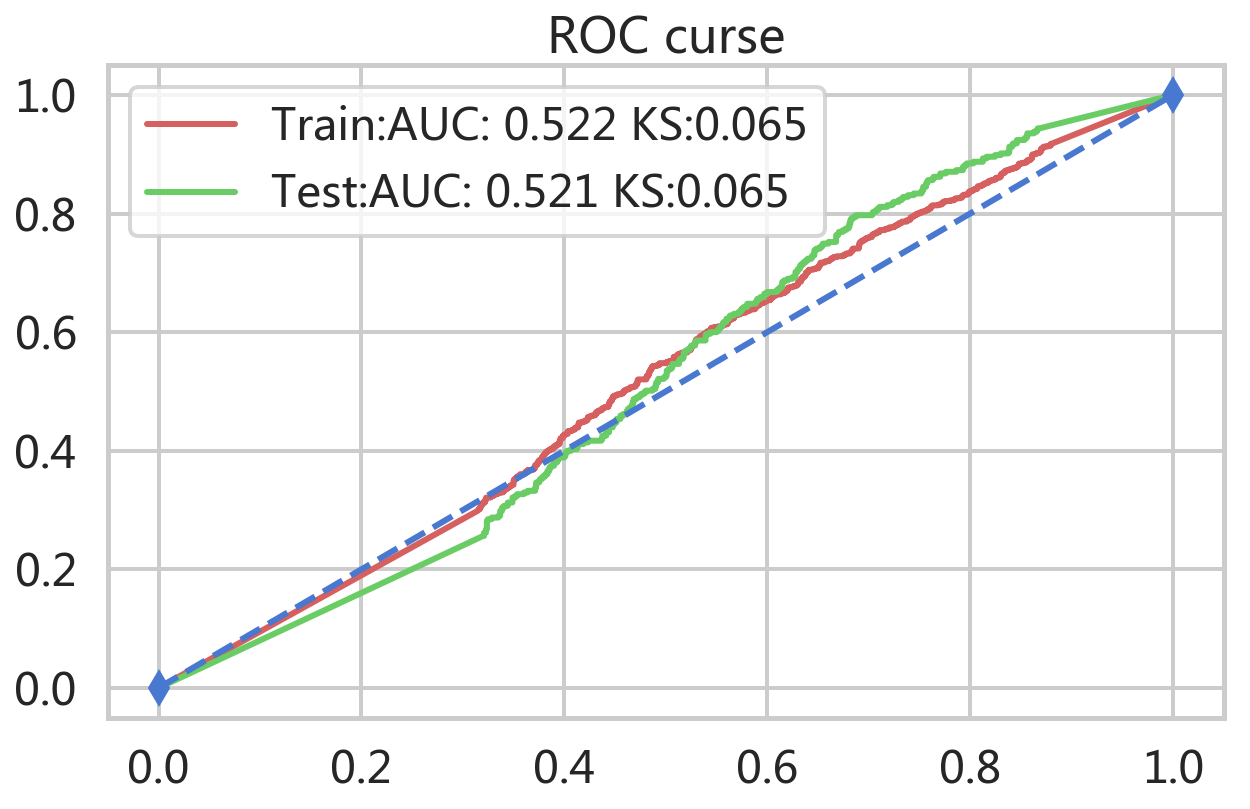

准确性：
Train：0.7481
Test：0.7512
召回率：
Train：0.0000
Test：0.0000
f1_score：
Train：0.0000
Test：0.0000
roc_auc：
Train：0.5000
Test：0.5000
KS：
Train：0.0000
Test：0.0000


D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


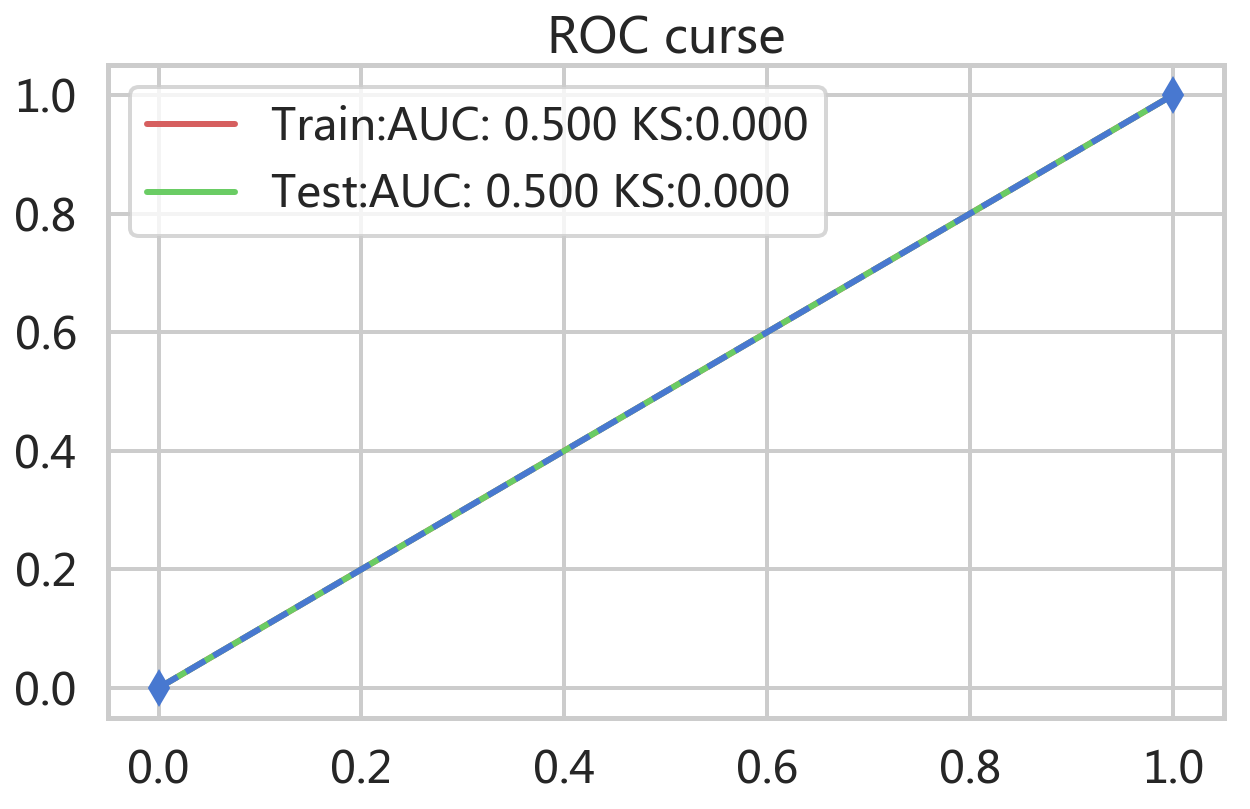

准确性：
Train：0.7481
Test：0.7512
召回率：
Train：0.0000
Test：0.0000
f1_score：
Train：0.0000
Test：0.0000
roc_auc：
Train：0.6020
Test：0.5966
KS：
Train：0.2087
Test：0.2005


D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda2_5.1.0_setup\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


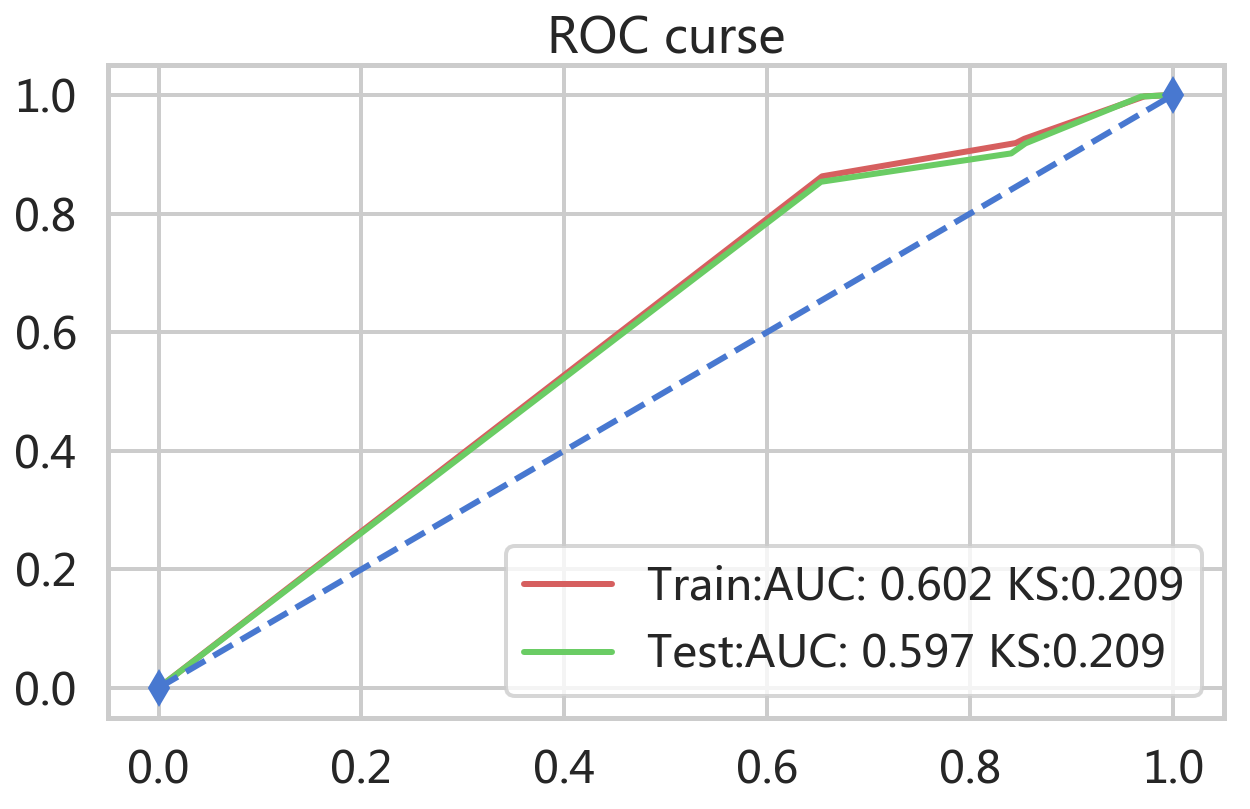

准确性：
Train：0.7033
Test：0.7106
召回率：
Train：0.2327
Test：0.1944
f1_score：
Train：0.2832
Test：0.2505
roc_auc：
Train：0.6502
Test：0.6382
KS：
Train：0.2415
Test：0.2290


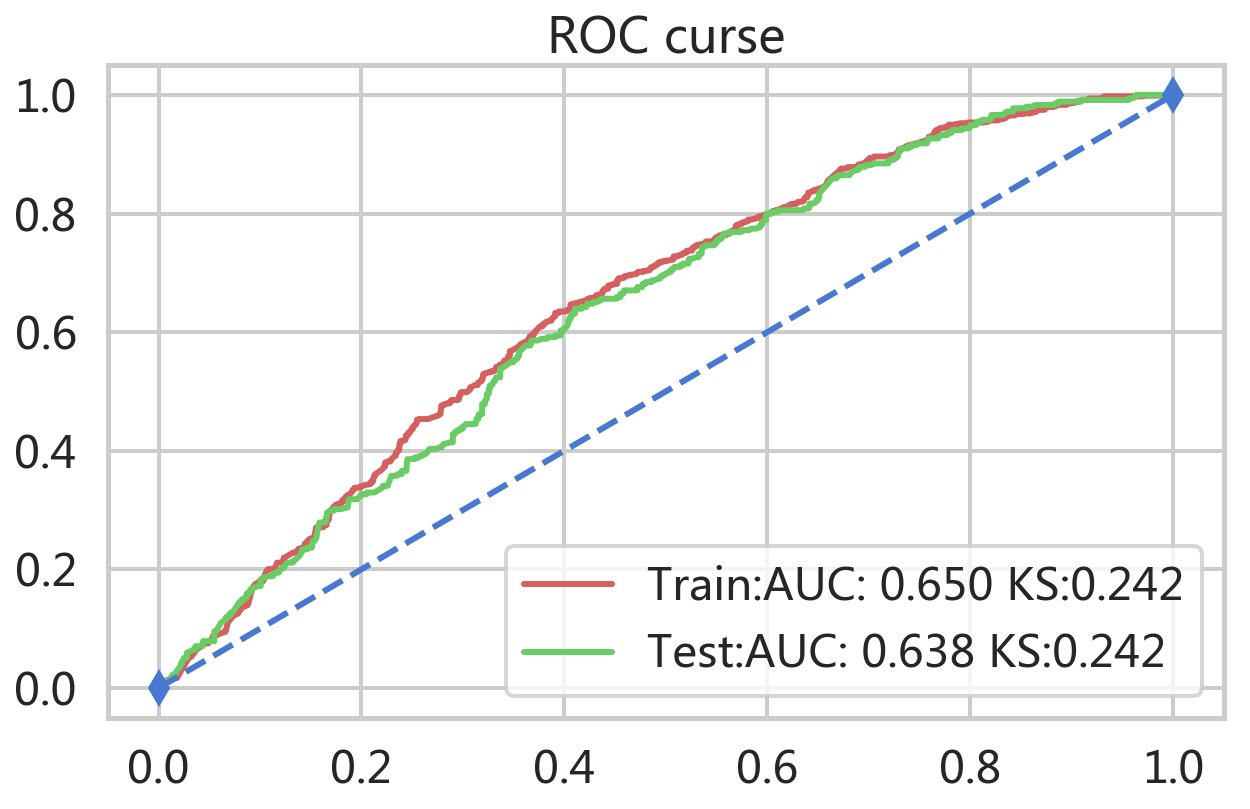

In [85]:
# 逻辑回归
model_metrics(lr, X_train, X_test, y_train, y_test)
# 多项式SVM
model_metrics(poly_svc, X_train, X_test, y_train, y_test)
# 决策树
model_metrics(dt, X_train, X_test, y_train, y_test)
# XGBoost
# model_metrics(xgb_model, X_train, X_test, y_train, y_test)
# lightGBM
model_metrics(lgb_model, X_train, X_test, y_train, y_test)